### Tries to parse pdf and generate structured format

In [11]:
%pip install instructor
%pip install pydantic
%pip install openai
%pip install deep-translator

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [12]:
import re
import json
import requests
import pandas as pd
from bs4 import BeautifulSoup
import instructor
from openai import OpenAI
from pydantic import BaseModel, Field
from deep_translator import GoogleTranslator


In [13]:
# Define the Pydantic models for the data extraction i am attempting to do

class InitialBudget(BaseModel):
    answer: float = Field(description="Initial budget of the project")
    chain_of_thought: str = Field(
        description="""Logical Steps that were taken to derive
        the final concluding statement"""
    )

class FinalCost(BaseModel):
    answer: float = Field(description="Final cost of the project")
    chain_of_thought: str = Field(
        description="""Logical Steps that were taken to derive
        the final concluding statement"""
    )

class EstimatedDuration(BaseModel):
    answer: int = Field(description="Estimated duration in days")
    chain_of_thought: str = Field(
        description="""Logical Steps that were taken to derive
        the final concluding statement"""
    )

class ActualDuration(BaseModel):
    answer: int = Field(description="Actual duration in days")
    chain_of_thought: str = Field(
        description="""Logical Steps that were taken to derive
        the final concluding statement"""
    )

##### Example response from llama3.2:3b 4 bit quant
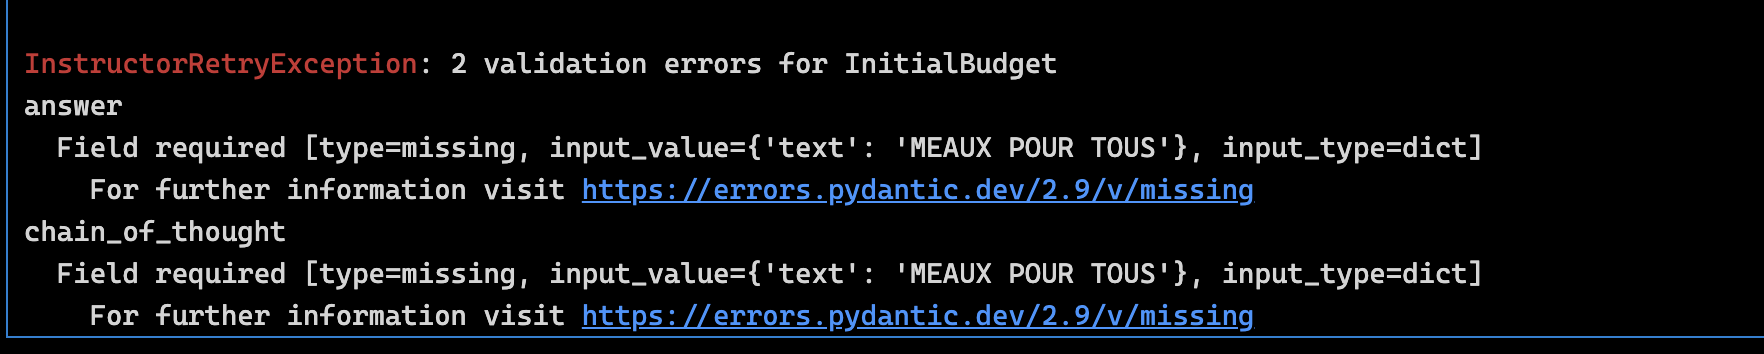

In [ ]:
# Using locally run smol models from ollama is so trash lol, because they have quantized the hell
# out of it, why will you serve llama 3.2:3b in 4bit quant 😭 doesn't follow pydantic model types
# and cannot reason over the document properly, i switched to the openai 4o because it is cheaper
# we can also use an open model like llama 405b in bf16 quant from
# https://app.hyperbolic.xyz/models/llama31-405b-base-bf-16/api but it's more expensive

# client = instructor.from_openai(OpenAI(
#   base_url="http://localhost:11434/v1",
#   api_key="ollama",  # required, but unused
#   ),
#   mode=instructor.Mode.JSON,
# )


client = instructor.from_openai(OpenAI(
  api_key="sk-proj---",
  ))

In [15]:
# Load the dataset
df = pd.read_csv('../dataset.csv')

# Load a random subset of the dataset for development
# TODO: Load the entire dataset
df = df.sample(2)


def extract_text(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    text = soup.get_text()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['extracted_text'] = df['fulltext'].apply(extract_text)

In [16]:
def translate_text(doc_id, french_text):
    output_dir = 'processed_text'

    # Remove special characters from document id
    doc_id = re.sub(r'\W+', '', doc_id)

    try:
        # Initialize translator and translate
        translator = GoogleTranslator(source='fr', target='en')

        # Handle long text by splitting into chunks
        chunk_size = 4500  # Google Translate limit
        chunks = [french_text[i:i+chunk_size] for i in range(0, len(french_text), chunk_size)]
        
        # Translate chunks and combine
        translated_chunks = [translator.translate(text) for text in chunks]
        translated_text = ' '.join(translated_chunks)
        
        # Save original and translated text to file for validation and return path
        with open(f'{output_dir}/{doc_id}_french.txt', 'w') as f:
            f.write(french_text)

        with open(f'{output_dir}/{doc_id}_english.txt', 'w') as f:
            f.write(translated_text)

    except Exception as e:
        print(f"Translation error: {str(e)}")

    return f'{output_dir}/{doc_id}_french.txt' , f'{output_dir}/{doc_id}_english.txt'

In [17]:
initial_budget_message = {
        "role": "system",
        "content": f"""
                You are a helpful AI Question Answerer. You are about to
                be passed a project description text in French by a User.

                Your task is to extract the initial budget of the project.
                Make sure to generate a series of logical steps and reason
                about the problem before generating a solution.
                """,
}
final_cost_message = {
        "role": "system",
        "content": f"""
                You are a helpful AI Question Answerer. You are about to
                be passed a project description text in French by a User.

                Your task is to extract the final cost of the project.
                Make sure to generate a series of logical steps and reason
                about the problem before generating a solution.
                """,
}

estimated_duration_message = {
        "role": "system",
        "content": f"""
                You are a helpful AI Question Answerer. You are about to
                be passed a project description text in French by a User.

                Your task is to extract the estimated duration of the project.
                Make sure to generate a series of logical steps and reason
                about the problem before generating a solution.
                """,
}

actual_duration_message = {
        "role": "system",
        "content": f"""
                You are a helpful AI Question Answerer. You are about to
                be passed a project description text in French by a User.

                Your task is to extract the actual duration of the project.
                Make sure to generate a series of logical steps and reason
                about the problem before generating a solution.
                """,
}


In [18]:


# Define a function to extract project details
def extract_project_details(doc_id, text):
    print(f"Extracting project details for document {doc_id}")
    model = "gpt-4o"
    user_message = {
                "role": "user",
                "content": text,
            }
    # Execute translation
    original_text_path, english_translation_path = translate_text(doc_id, text)

    handle_initial_budget_response = client.chat.completions.create(
        model = model,
        messages = [
            initial_budget_message,
            user_message,
            ],
        response_model = InitialBudget,
    )

    print("The initial budget is: ", handle_initial_budget_response.answer)
    print("The chain of thought is: ", handle_initial_budget_response.chain_of_thought)

    handle_final_cost_response = client.chat.completions.create(
        model = model,
        messages = [
            final_cost_message,
            user_message,
            ],
        response_model = FinalCost,
    )

    print("The final cost is: ", handle_final_cost_response.answer)
    print("The chain of thought is: ", handle_final_cost_response.chain_of_thought)

    handle_estimated_duration_response = client.chat.completions.create(
        model = model,
        messages = [
            estimated_duration_message,
            user_message,
            ],
        response_model = EstimatedDuration,
    )

    print("The estimated duration is: ", handle_estimated_duration_response.answer)
    print("The chain of thought is: ", handle_estimated_duration_response.chain_of_thought)

    handle_actual_duration_response = client.chat.completions.create(

        model = model,
        messages = [
            actual_duration_message,
            user_message,
            ],
        response_model = ActualDuration,
    )

    print("The actual duration is: ", handle_actual_duration_response.answer)
    print("The chain of thought is: ", handle_actual_duration_response.chain_of_thought)

    return {
        "original_text_path": original_text_path,
        "english_translation_path": english_translation_path,
        "initial_budget": handle_initial_budget_response.answer,
        "initial_budget_chain_of_thought": handle_initial_budget_response.chain_of_thought,
        "final_cost": handle_final_cost_response.answer,
        "final_cost_chain_of_thought": handle_final_cost_response.chain_of_thought,
        "estimated_duration": handle_estimated_duration_response.answer,
        "estimated_duration_chain_of_thought": handle_estimated_duration_response.chain_of_thought,
        "actual_duration": handle_actual_duration_response.answer,
        "actual_duration_chain_of_thought": handle_actual_duration_response.chain_of_thought,
    }

# Apply the function to the subset of the dataset
project_details_list = df.apply( lambda x: extract_project_details(x['doc_id'], x['extracted_text']), axis=1)

Extracting project details for document 5808/974705cef903edc22c404e33840ea65312886808_324b63_cdd552fe6
The initial budget is:  0.0
The chain of thought is:  Upon reviewing the document, it mainly consists of the minutes of a municipal council meeting. It includes election results, budget decisions, participation fees for communal services, and other local administrative topics. However, the document does not explicitly mention an 'initial budget' figure typical for a new project or annual budget setting. Instead, it discusses a 'Budget Principal: décision modificative N°3' which involves a reallocation of existing budgetary funds amounting to changes of +100,000 € in maintenance and corresponding -100,000 € in transfers to various sections. This is not indicative of an 'initial budget' but a modification of an existing budget. Hence, the initial budget of the project is not clearly specified in the document as it focuses on budget adjustments rather than starting budgets.
The final cos

In [19]:
# Save the results as formatted json for validation
with open('project_details.json', 'w') as f:
    json.dump(project_details_list.to_dict(), f, indent=4)